<a href="https://colab.research.google.com/github/chakma21/BTP/blob/main/TargetCluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required packages (Colab)
!pip install -q sentence-transformers openpyxl scipy

import io
import pandas as pd
from collections import Counter, defaultdict
from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, fcluster
from google.colab import files


this code is doing generalization

In [ ]:

# -------------------------
# 1) Upload file (CSV or Excel)
# -------------------------
print("Upload your Excel/CSV file (it should contain a column of keywords).")
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
print("Loaded file:", file_name)

# read file into DataFrame
if file_name.lower().endswith('.csv'):
    df = pd.read_csv(io.BytesIO(uploaded[file_name]))
else:
    df = pd.read_excel(io.BytesIO(uploaded[file_name]))

print("Columns found:", df.columns.tolist())

# -------------------------
# 2) Detect which column to use for keywords
# -------------------------
# Preference: a column name containing 'keyword' (case-insensitive).
candidate_cols = [c for c in df.columns if 'keyword' in c.lower()]
if candidate_cols:
    keyword_col = candidate_cols[0]
else:
    # fallback: first text/object column, otherwise first column
    obj_cols = df.select_dtypes(include=['object']).columns.tolist()
    keyword_col = obj_cols[0] if obj_cols else df.columns[0]

print("Using column for keywords:", keyword_col)

# Extract keywords (preserving order). Keep blanks/NaNs removable.
kw_series = df[keyword_col].astype(str).str.strip()
# Keep only non-empty for clustering (but we'll map back everything later)
mask_nonempty = kw_series.str.len() > 0
original_keywords = kw_series[mask_nonempty].tolist()
if len(original_keywords) == 0:
    raise ValueError("No non-empty keyword values found in the selected column.")

print(f"Number of non-empty keywords to process: {len(original_keywords)}")

# -------------------------
# 3) Normalize text for clustering (simple normalization)
# -------------------------
# we lowercase for more robust semantic grouping; keep original strings too
normalized = [s.lower() for s in original_keywords]

# -------------------------
# 4) Create embeddings
# -------------------------
print("Loading sentence-transformer model and creating embeddings (may take a moment)...")
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(normalized, show_progress_bar=True, convert_to_numpy=True)

# -------------------------
# 5) Hierarchical clustering (cosine distance + average linkage)
#    We use scipy linkage + fcluster so distance threshold works reliably.
# -------------------------
# distance threshold: tweak this: smaller -> stricter (fewer merges)
distance_threshold = 0.48   # <-- change this if you want stricter/looser grouping
print("Computing pairwise distances and clustering (distance_threshold =", distance_threshold, ") ...")
condensed_dist = pdist(embeddings, metric='cosine')  # condensed distances
Z = linkage(condensed_dist, method='average')
labels = fcluster(Z, t=distance_threshold, criterion='distance')  # labels start at 1

# -------------------------
# 6) Build clusters and choose representatives
# -------------------------
clusters = defaultdict(list)
for idx, lab in enumerate(labels):
    clusters[lab].append(idx)

cluster_rows = []
normalized_to_rep = {}  # map normalized form -> representative (string)
for lab, idxs in clusters.items():
    members_original = [original_keywords[i] for i in idxs]
    members_normalized = [normalized[i] for i in idxs]
    # choose representative: most frequent normalized form; tie-breaker = longest original
    freq = Counter(members_normalized)
    most_common_norm = freq.most_common(1)[0][0]
    # among originals choose the one matching the most_common_norm (preserve casing) with max length
    candidates = [s for s in members_original if s.lower() == most_common_norm]
    if candidates:
        representative = max(candidates, key=len)
    else:
        representative = max(members_original, key=len)
    # fill mapping and cluster row
    for norm in set(members_normalized):
        normalized_to_rep[norm] = representative
    cluster_rows.append({
        "Representative": representative,
        "Members": ", ".join(sorted(set(members_original), key=lambda x: (x.lower(), len(x)))),
        "Count": len(members_original)
    })

# sort cluster rows by descending size (optional)
cluster_rows = sorted(cluster_rows, key=lambda r: -r["Count"])
clusters_df = pd.DataFrame(cluster_rows)

# -------------------------
# 7) Map the full original dataframe's keyword column to generalized reps
# -------------------------
def map_to_rep(val):
    if pd.isna(val):
        return val
    s = str(val).strip()
    if s == "":
        return s
    rep = normalized_to_rep.get(s.lower())
    return rep if rep is not None else s

df_out = df.copy()
df_out['Generalized_Keyword'] = df_out[keyword_col].apply(map_to_rep)

# -------------------------
# 8) Save results to Excel (two sheets)
# -------------------------
output_file = "generalized_and_clusters.xlsx"
with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
    df_out.to_excel(writer, sheet_name="generalized", index=False)
    clusters_df.to_excel(writer, sheet_name="clusters", index=False)

files.download(output_file)
print("✅ Done — downloaded:", output_file)
print("Saved two sheets: 'generalized' (original + Generalized_Keyword) and 'clusters' (Representative, Members, Count).")
print()
print("Sample clusters (top 10):")
print(clusters_df.head(10).to_string(index=False))
print()
print("If you want stricter clustering (fewer merges), lower 'distance_threshold' (e.g., 0.20).")
print("If you want looser clustering (more merges), raise it (e.g., 0.35).")


Upload your Excel/CSV file (it should contain a column of keywords).


Saving DEM_rake_yake_keywordsNEW.csv to DEM_rake_yake_keywordsNEW.csv
Loaded file: DEM_rake_yake_keywordsNEW.csv
Columns found: ['Keyword', 'Score']
Using column for keywords: Keyword
Number of non-empty keywords to process: 106
Loading sentence-transformer model and creating embeddings (may take a moment)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Computing pairwise distances and clustering (distance_threshold = 0.48 ) ...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Done — downloaded: generalized_and_clusters.xlsx
Saved two sheets: 'generalized' (original + Generalized_Keyword) and 'clusters' (Representative, Members, Count).

Sample clusters (top 10):
       Representative                                                                                          Members  Count
       prime minister chief minister, finance minister, home minister, prime minister, union minister, union ministers      7
  narendra government   minister narendra, narendra, narendra government, narendra modi, pm narendra, support narendra      7
             rahul pm                               gandhi modi, mahesh sharma, manmohan singh, rahul gandhi, rahul pm      5
              bjp mps                                  bjp chief, bjp leader, bjp mps, bjp president, bjp spokesperson      5
                  mps mps, parliament proceedings, parliamentary committee, parliamentary meeting, parliamentary party      5
              shah pm                               

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 21.8 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


Unique normalized keywords: 97


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


HDBSCAN produced 9 clusters (noise label -1 count: 14)
Top clusters:


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,ClusterLabel,Representative,MembersNormalized,SomeOriginals,Count,Kind
0,0,corruption,"adequate note, america, black economy, black m...","teller machines, america would, machines stock...",29,cluster
1,-1,electric pole,"electric pole, graft case, indira yojana, jan ...","pritam munde, shah pm, official improvisation,...",14,noise
2,3,chief minister,"chief, chief minister, congress leader, congre...","home minister, minister jaitley, prime ministe...",11,cluster
3,5,na na,"also back, boast back, hav eto, ki chidiya, na...","one swoop, ki chidiya, hav eto, boast back, sw...",8,cluster
4,8,bjp leader,"bjp leader, bjp president, bjp spokesperson, g...","bjp leader, bjp spokesperson, trinamool leader...",7,cluster
5,1,parliamentary committee,"bilateral treaty, parliament proceeding, parli...","parliamentary committee, parliamentary meeting...",6,cluster
6,6,shah,"amit shah, saffron baba, shah, sibal, surjewal...","saffron baba, surjewala also, b shah, yadav on...",6,cluster
7,7,mahesh sharma,"banerjee, gurumurthy today, jaitley, mahesh sh...","jaitley also, banerjee also, mahesh sharma, ma...",6,cluster
8,2,mp,"mp, mps, pm, pm address, pm war","pm war, bjp mps, mps, pm could, pm addresses",5,cluster
9,4,narendra,"minister narendra, narendra, narendra governme...","support narendra, pm narendra, narendra, naren...",5,cluster


Silhouette score (non-noise): 0.4216


<Figure size 800x400 with 0 Axes>

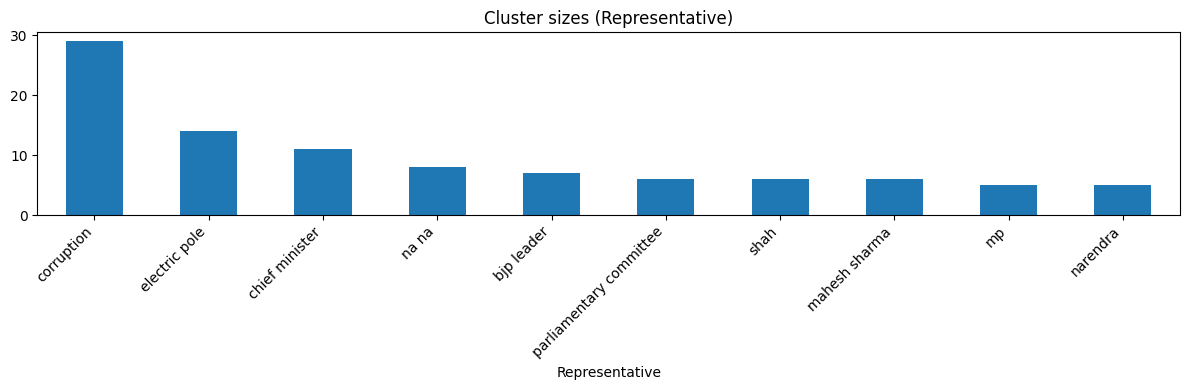

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved: clusters_umap_hdbscan.xlsx


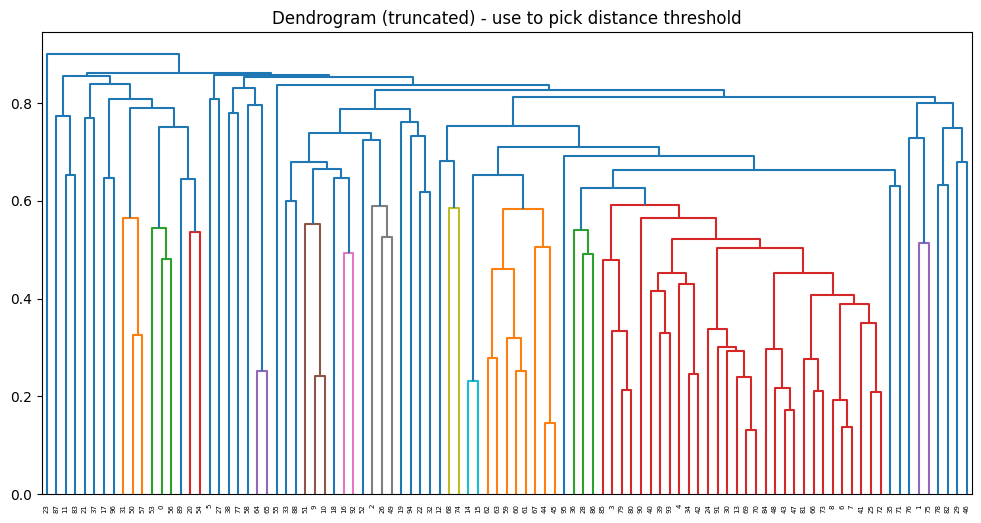

In [ ]:
# Improved clustering: UMAP + HDBSCAN + medoid representatives (Colab-ready)
!pip install -q sentence-transformers umap-learn hdbscan rapidfuzz openpyxl

import io, re, math
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import spacy
from rapidfuzz import fuzz, process

# --- 0. load spaCy model (download if needed) ---
try:
    nlp = spacy.load("en_core_web_sm")
except Exception:
    !python -m spacy download en_core_web_sm
    nlp = spacy.load("en_core_web_sm")

# -------------------------
# Inputs: either give 'df' containing keyword column,
# or a python list 'original_keywords'.
# If using existing df (from your upload), uncomment and use:
# df = <your dataframe>
# original_keywords = df[keyword_col].astype(str).str.strip().tolist()
# -------------------------

# For demo: if not set, try to read the previously uploaded file (you used files.upload earlier)
try:
    original_keywords
except NameError:
    # fallback: try reading generalized_and_clusters.xlsx from session
    try:
        df = pd.read_excel("generalized_and_clusters.xlsx", sheet_name="generalized")
        # pick a column that looks like keywords
        candidate = [c for c in df.columns if 'keyword' in c.lower()]
        keyword_col = candidate[0] if candidate else df.columns[0]
        original_keywords = df[keyword_col].astype(str).str.strip().tolist()
        print("Loaded keywords from generalized_and_clusters.xlsx ->", keyword_col)
    except Exception:
        raise RuntimeError("Please set `original_keywords` list or place an excel/csv in the runtime.")

# -------------------------
# 1) Preprocess / normalize keywords
# -------------------------
def normalize_phrase(sp, keep_pos=("NOUN","PROPN","ADJ")):
    sp = str(sp).strip()
    sp = re.sub(r'[_\-\—]+', ' ', sp)              # normalize dashes/underscores
    sp = re.sub(r"[^\w\s']", ' ', sp)              # remove punctuation (keep apostrophes optionally)
    doc = nlp(sp)
    toks = []
    for t in doc:
        if t.is_stop or t.is_punct or t.like_num:
            continue
        # keep only desired POS to focus on nouns/proper-nouns/adjectives
        if t.pos_ in keep_pos:
            toks.append(t.lemma_.lower())
        else:
            # fallback: allow short tokens (1-2 chars) careful
            # skip otherwise
            continue
    res = " ".join(toks).strip()
    # fallback: keep cleaned lower if nothing remained
    return res if res else sp.lower()

normalized_list = [normalize_phrase(k) for k in original_keywords]
# build mapping from normalized -> list(originals)
norm_to_originals = defaultdict(list)
for orig, norm in zip(original_keywords, normalized_list):
    norm_to_originals[norm].append(orig)

# deduplicate normalized phrases (we'll cluster unique normalized forms)
uniq_norms = sorted(list(dict.fromkeys(normalized_list)))  # preserve order

print(f"Unique normalized keywords: {len(uniq_norms)}")

# -------------------------
# 2) Create embeddings (option: context-aware)
#    If you have 'sentences' list, compute context-aware embeddings by averaging
# -------------------------
USE_CONTEXT = False   # set True to use sentence-context averaging (slower but often better)
MODEL_NAME = "all-mpnet-base-v2"   # higher-quality embedding model

model = SentenceTransformer(MODEL_NAME)

if USE_CONTEXT and 'sentences' in globals():
    # map normalized keyword to sentences in which it appears (simple substring match)
    kw_to_sentences = defaultdict(list)
    sents_lower = [s.lower() for s in sentences]
    for i, norm in enumerate(uniq_norms):
        norm_tok = norm.lower()
        for s in sents_lower:
            if norm_tok and norm_tok in s:
                kw_to_sentences[norm].append(s)
        # fallback: if none found, optionally match original forms
        if len(kw_to_sentences[norm]) == 0:
            for orig in norm_to_originals.get(norm, []):
                orig_l = orig.lower()
                for s in sents_lower:
                    if orig_l in s:
                        kw_to_sentences[norm].append(s)
    # compute embedding for each keyword as mean of up to K sentences
    embeddings = []
    for norm in uniq_norms:
        sents = kw_to_sentences[norm][:16]   # cap to 16 sentences to avoid huge cost
        if sents:
            emb = model.encode(sents, convert_to_numpy=True)
            emb = emb.mean(axis=0)
        else:
            emb = model.encode([norm], convert_to_numpy=True)[0]
        embeddings.append(emb)
    embeddings = np.vstack(embeddings)
else:
    embeddings = model.encode(uniq_norms, show_progress_bar=True, convert_to_numpy=True)

# -------------------------
# 3) UMAP reduction (to < 10 dims for HDBSCAN)
# -------------------------
umap_transform = umap.UMAP(n_neighbors=15, n_components=5, metric='cosine', random_state=42)
emb_umap = umap_transform.fit_transform(embeddings)

# -------------------------
# 4) HDBSCAN clustering
# -------------------------
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, metric='euclidean', cluster_selection_method='eom')
labels = clusterer.fit_predict(emb_umap)   # -1 => noise

num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print("HDBSCAN produced", num_clusters, "clusters (noise label -1 count: {})".format((labels==-1).sum()))

# -------------------------
# 5) Build cluster rows + medoid representative
# -------------------------
cluster_map = defaultdict(list)
for idx, lab in enumerate(labels):
    cluster_map[lab].append(idx)

cluster_rows = []
for lab, idxs in sorted(cluster_map.items(), key=lambda x: (-len(x[1]), x[0])):
    members = [uniq_norms[i] for i in idxs]
    if lab == -1:
        rep = members[0]  # noise, just pick first
        kind = "noise"
    else:
        # pick medoid: member whose embedding is closest to the cluster centroid
        cluster_embs = embeddings[idxs]
        centroid = cluster_embs.mean(axis=0)
        dists = np.linalg.norm(cluster_embs - centroid[None,:], axis=1)
        medoid_idx = idxs[int(np.argmin(dists))]
        rep = uniq_norms[medoid_idx]
        kind = "cluster"
    # map back to original strings (show a few)
    orig_examples = list({o for m in members for o in norm_to_originals.get(m, [])})
    cluster_rows.append({
        "ClusterLabel": int(lab),
        "Representative": rep,
        "MembersNormalized": ", ".join(members),
        "SomeOriginals": ", ".join(orig_examples[:8]),
        "Count": len(members),
        "Kind": kind
    })

clusters_df = pd.DataFrame(cluster_rows).sort_values(by="Count", ascending=False).reset_index(drop=True)
print("Top clusters:")
display(clusters_df.head(15))

# -------------------------
# 6) Optional diagnostics: silhouette (exclude noise), cluster size plot
# -------------------------
if num_clusters > 1:
    mask = labels != -1
    try:
        sil = silhouette_score(emb_umap[mask], labels[mask])
        print("Silhouette score (non-noise):", round(sil, 4))
    except Exception as e:
        print("Silhouette score error:", e)

plt.figure(figsize=(8,4))
clusters_df.plot(kind='bar', x='Representative', y='Count', legend=False, figsize=(12,4))
plt.xticks(rotation=45, ha='right')
plt.title("Cluster sizes (Representative)")
plt.tight_layout()
plt.show()

# -------------------------
# 7) Save mapping back to original df if exists
# -------------------------
# map each normalized value to its representative (medoid rep)
norm_to_rep = {}
for _, row in clusters_df.iterrows():
    rep = row['Representative']
    members_norm = row['MembersNormalized'].split(", ")
    for m in members_norm:
        norm_to_rep[m] = rep

# now map original df if present
if 'df' in globals():
    def map_to_rep_val(v):
        s = str(v).strip()
        norm = normalize_phrase(s)
        return norm_to_rep.get(norm, s)
    df_out = df.copy()
    df_out['Representative'] = df_out[keyword_col].apply(map_to_rep_val)
    output_file = "clusters_umap_hdbscan.xlsx"
    with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
        df_out.to_excel(writer, sheet_name="generalized", index=False)
        clusters_df.to_excel(writer, sheet_name="clusters", index=False)
    from google.colab import files as gcf
    gcf.download(output_file)
    print("Saved:", output_file)
else:
    print("No original dataframe 'df' found in runtime; clusters_df is available for inspection.")

# -------------------------
# 8) If you prefer hierarchical (dendrogram) to pick a threshold manually:
# -------------------------
# plt.figure(figsize=(12, 6))
# condensed = pdist(embeddings, metric='cosine')
# Z = linkage(condensed, method='average')
# dendrogram(Z, truncate_mode='level', p=40, color_threshold=0.6)
# plt.title("Dendrogram (truncated) - use to pick distance threshold")
# plt.show()



Cluster Distribution Bar Chart

<Figure size 1200x600 with 0 Axes>

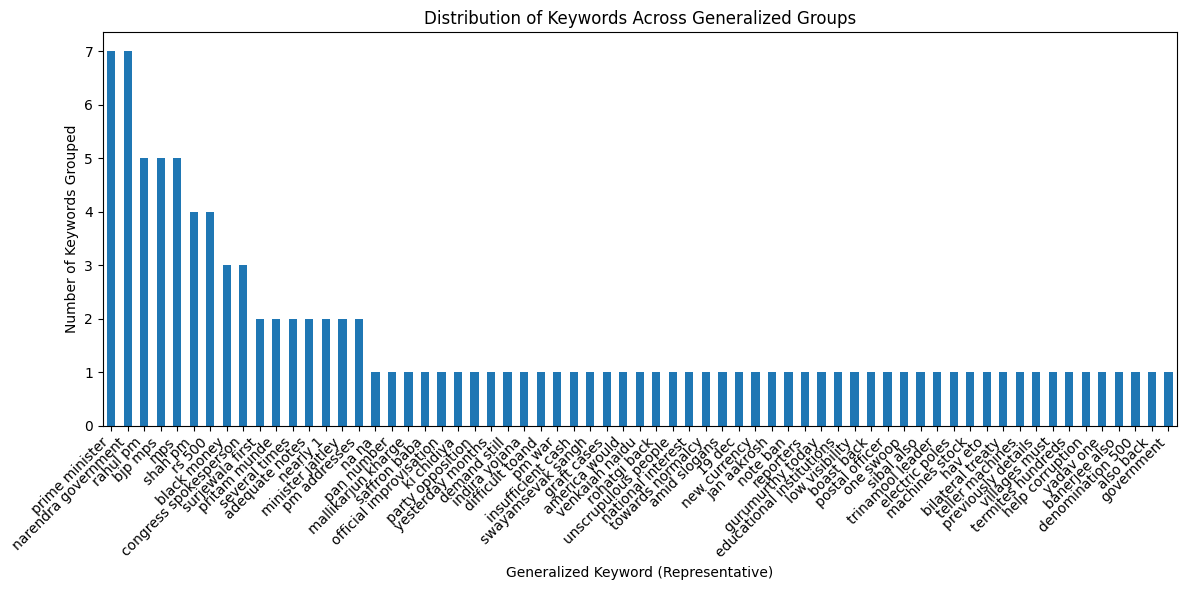

In [ ]:
import matplotlib.pyplot as plt

# Bar chart of cluster sizes
plt.figure(figsize=(12,6))
clusters_df.plot(
    x="Representative",
    y="Count",
    kind="bar",
    legend=False,
    figsize=(12,6)
)
plt.xlabel("Generalized Keyword (Representative)")
plt.ylabel("Number of Keywords Grouped")
plt.title("Distribution of Keywords Across Generalized Groups")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Cluster Visualization

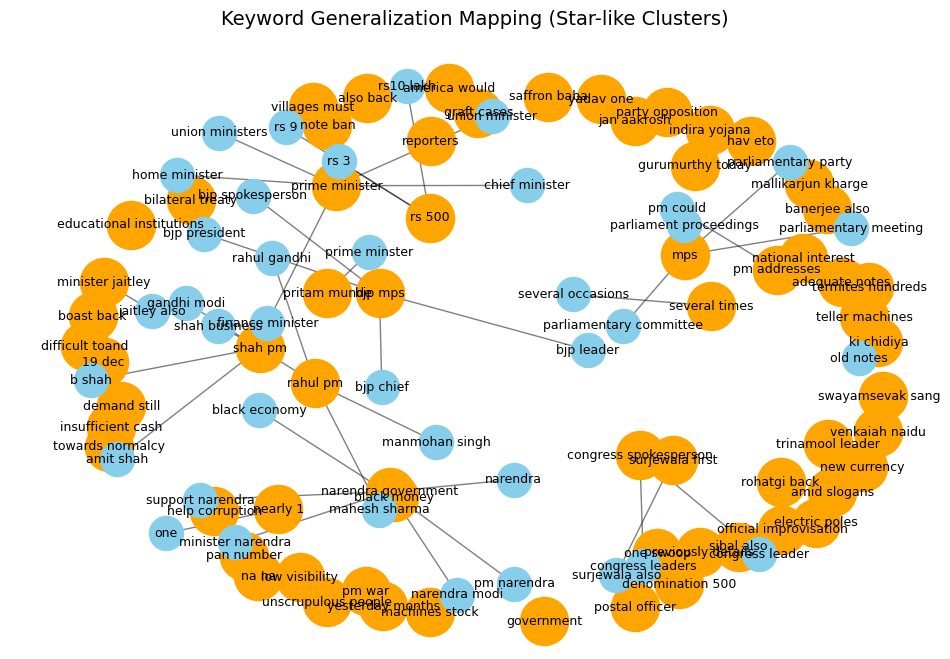

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Build graph
G = nx.Graph()

for _, row in clusters_df.iterrows():
    rep = row["Representative"]
    members = row["Members"].split(", ")

    # Add representative node
    G.add_node(rep, type="rep")

    # Add member nodes + edges to representative
    for m in members:
        if m != rep:  # skip if same
            G.add_node(m, type="member")
            G.add_edge(rep, m)

# Draw graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5, seed=42)  # nice layout

# Separate representative vs members
rep_nodes = [n for n, d in G.nodes(data=True) if d['type']=="rep"]
member_nodes = [n for n, d in G.nodes(data=True) if d['type']=="member"]

# Draw representatives (bigger & different color)
nx.draw_networkx_nodes(G, pos, nodelist=rep_nodes, node_size=1200, node_color="orange")
nx.draw_networkx_nodes(G, pos, nodelist=member_nodes, node_size=600, node_color="skyblue")

# Draw edges + labels
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=9)

plt.title("Keyword Generalization Mapping (Star-like Clusters)", fontsize=14)
plt.axis("off")
plt.show()


this code is adding a new column for every keyword column with the genralized word for the keyword

In [ ]:
# # Install dependencies
# !pip install pandas openpyxl

# import pandas as pd
from google.colab import files

# ===== Function to read file based on extension =====
def read_file(file_path):
    if file_path.lower().endswith(".csv"):
        return pd.read_csv(file_path)
    else:
        return pd.read_excel(file_path)


# ===== 1. UPLOAD FILES =====
print("Upload the file with 'keyword' and 'Generalized_Keyword'")
uploaded1 = files.upload()
file1 = list(uploaded1.keys())[0]

print("Upload the file with keyword1, keyword2, keyword3, and sentiment")
uploaded2 = files.upload()
file2 = list(uploaded2.keys())[0]

# ===== 2. READ FILES (supports CSV or Excel) =====
df_mapping = read_file(file1)  # first file
df_data = read_file(file2)     # second file

# Ensure correct column names in mapping file
mapping_col_keyword = None
mapping_col_general = None

for col in df_mapping.columns:
    if "keyword" in col.lower() and "generalized" not in col.lower():
        mapping_col_keyword = col
    elif "generalized" in col.lower():
        mapping_col_general = col

if mapping_col_keyword is None or mapping_col_general is None:
    raise ValueError("Could not detect keyword/generalized keyword columns in mapping file.")

# Create dictionary for mapping
general_map = dict(zip(df_mapping[mapping_col_keyword].astype(str),
                       df_mapping[mapping_col_general].astype(str)))

# ===== 3. Add generalized keyword columns =====
for i in range(1, 4):
    kw_col = f"keyword{i}"
    gen_col = f"generalized_keyword{i}"
    if kw_col in df_data.columns:
        df_data[gen_col] = df_data[kw_col].astype(str).map(general_map).fillna("")


# ===== 4. SAVE NEW FILE =====
output_file = "keywords_with_generalized.xlsx"
df_data.to_excel(output_file, index=False)
# output_file = "keywords_with_generalized.csv"
# df_data.to_csv(output_file, index=False)
files.download(output_file)

print(f"✅ Done! File saved as {output_file}")


Upload the file with 'keyword' and 'Generalized_Keyword'


Saving generalized_targetsHW.xlsx to generalized_targetsHW.xlsx
Upload the file with keyword1, keyword2, keyword3, and sentiment


Saving keyword_relationshipsHW.csv to keyword_relationshipsHW.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Done! File saved as keywords_with_generalized.xlsx
